In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#Import Libraries
# Visual representation libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

In [2]:
# Reading The Datasets

# 1. Session Dataset

read1 = pd.read_csv('C:/Users/saraswathi/Desktop/Reading_lists/Github/dataset/fraud detection E-commerce/TeaLeafOutput/session_related.csv')
session_df = pd.DataFrame(read1)

# 2. Generic Dataset

read2 = pd.read_csv('C:/Users/saraswathi/Desktop/Reading_lists/Github/dataset/fraud detection E-commerce/TeaLeafOutput/generic_outliers_data.csv')
outlier_df = pd.DataFrame(read2)

# 3. Delivery Dataset

read3 = pd.read_csv('C:/Users/saraswathi/Desktop/Reading_lists/Github/dataset/fraud detection E-commerce/TeaLeafOutput/delivery_related.csv')
delivery_df = pd.DataFrame(read3)


In [3]:
#data cleaning and merging
ds_merge_df = pd.merge(delivery_df,session_df,on='OrderId')
df = pd.merge(ds_merge_df,outlier_df,on='CustId')

In [4]:
#Encoder
from sklearn.preprocessing import LabelEncoder
categorical = ['IsValidAddress','IsAddchangeRecently','IsAddchangeonDel','IsDeliveryRejected','IsProductConsumable','IsOneTimeUseProduct','IsOfferCodeApplied','IsValidGeo','OccupationalLevel','IncomeLevel']

label_encoder = LabelEncoder()
for col in categorical:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

df=df.iloc[:df.shape[0]]

In [5]:
df['AgeGroup'] = pd.cut(df['Age'], [10,15,18,21,24,27,30,33,35,40,50,100],
                            labels=['0', '1', '2','3','4','5','6','7','8','9','10'])
df['domain'] = df['EmailId'].str.split('@').str[1]
def ip_to_int(ip_ser):
    ips = ip_ser.str.split('.', expand=True).astype(np.int16).values
    mults = np.tile(np.array([24, 16, 8, 0]), len(ip_ser)).reshape(ips.shape)
    return np.sum(np.left_shift(ips, mults), axis=1)
df['_IP_start_session'] = ip_to_int(df.IP_start_session)
df['_IP_end_session'] = ip_to_int(df.IP_end_session)
df.head()

,CustId,OrderId,ProductId,IsValidAddress,IsAddchangeRecently,IsAddchangeonDel,IsDeliveryRejected,OriginalPrice,PaidPrice,OrderDate,...,MacAddress,AvgPurchase,City,OccupationalLevel,IncomeLevel,Pincode,AgeGroup,domain,_IP_start_session,_IP_end_session
0,47019,41601,41601,1,0,1,1,2711,2711,25/01/2019,...,1D-BA-45-3F-E5-43,99522,Latur,0,3,413512,3,yahoo.com,1664613345,1664613345
1,20242,30352,30352,0,1,0,0,2713,2710,06/02/2019,...,65-D1-F3-62-F7-44,3491,Mumbai G.P.O.,0,4,400001,1,hotmail.com,-822254278,-822254278
2,79619,12328,12328,1,0,1,1,4146,4142,12/01/2019,...,DF-6D-BF-6C-23-59,5262,Chhatarpur City,1,4,471001,1,gmail.com,-1745184684,-1745184684
3,79619,80750,80750,0,1,0,0,2662,2662,19/01/2019,...,DF-6D-BF-6C-23-59,5262,Chhatarpur City,1,4,471001,1,gmail.com,83846125,83866387
4,80669,19203,19203,1,0,1,0,2709,2707,27/03/2019,...,49-55-60-A5-F5-2B,4957,Sunamura,0,4,799131,1,gmail.com,1543308288,1543308288


In [6]:
#date change
df['OrderDate'] =  pd.to_datetime(df['OrderDate'],format='%d/%m/%Y')
df['AddressChangeDate'] =  pd.to_datetime(df['AddressChangeDate'],format='%d/%m/%Y')
df['DeliveryDate'] =  pd.to_datetime(df['DeliveryDate'],format='%d/%m/%Y')
df['ReplacementDate'] =  pd.to_datetime(df['ReplacementDate'],format='%d/%m/%Y')

def extract_date(df,column):
    df[column+"_year"] = df[column].apply(lambda x: x.year) 
    df[column+"_month"] = df[column].apply(lambda x: x.month)
    df[column+"_date"] = df[column].apply(lambda x: x.day)    

extract_date(df,'OrderDate')
extract_date(df,'AddressChangeDate')
extract_date(df,'DeliveryDate')
extract_date(df,'ReplacementDate')
df.head()

,CustId,OrderId,ProductId,IsValidAddress,IsAddchangeRecently,IsAddchangeonDel,IsDeliveryRejected,OriginalPrice,PaidPrice,OrderDate,...,OrderDate_date,AddressChangeDate_year,AddressChangeDate_month,AddressChangeDate_date,DeliveryDate_year,DeliveryDate_month,DeliveryDate_date,ReplacementDate_year,ReplacementDate_month,ReplacementDate_date
0,47019,41601,41601,1,0,1,1,2711,2711,2019-01-25,...,25,2018,11,20,2019,1,28,2019,2,1
1,20242,30352,30352,0,1,0,0,2713,2710,2019-02-06,...,6,2019,2,3,2019,2,10,2019,2,17
2,79619,12328,12328,1,0,1,1,4146,4142,2019-01-12,...,12,2018,7,30,2019,1,22,2019,2,1
3,79619,80750,80750,0,1,0,0,2662,2662,2019-01-19,...,19,2018,9,15,2019,1,26,2019,1,31
4,80669,19203,19203,1,0,1,0,2709,2707,2019-03-27,...,27,2018,6,14,2019,4,3,2019,4,6


In [7]:
#datacleanup
print("Before", df.shape)
features_drop = ['Age','EmailId', 'MobileNo','MacAddress', 'IP_start_session', 'IP_end_session',
                'City','CustId','OrderId','ProductId','OrderDate', 'AddressChangeDate','DeliveryDate',
                'ReplacementDate']
train_data = df.drop(features_drop, axis=1)


Before (100000, 47)


In [8]:
#encoding target variable
#preprocessing target
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# Encode labels in column 'fraud'. 
train_data['Fraud']= le.fit_transform(train_data['Fraud']) 

labels = train_data['Fraud']
features = train_data.drop('Fraud', axis=1)
print("After",train_data.shape)

After (100000, 33)


In [9]:
#hotencoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
features = features.apply(LabelEncoder().fit_transform)
features.head()


,IsValidAddress,IsAddchangeRecently,IsAddchangeonDel,IsDeliveryRejected,OriginalPrice,PaidPrice,IsProductConsumable,IsOneTimeUseProduct,IsOfferCodeApplied,Session_Pincode,...,OrderDate_date,AddressChangeDate_year,AddressChangeDate_month,AddressChangeDate_date,DeliveryDate_year,DeliveryDate_month,DeliveryDate_date,ReplacementDate_year,ReplacementDate_month,ReplacementDate_date
0,1,0,1,1,1711,1728,1,0,0,134,...,24,0,10,19,0,0,27,0,1,0
1,0,1,0,0,1713,1727,1,1,0,383,...,5,1,1,2,0,1,9,0,1,16
2,1,0,1,1,3146,3159,1,0,1,522,...,11,0,6,29,0,0,21,0,1,0
3,0,1,0,0,1662,1679,1,1,1,787,...,18,0,8,14,0,0,25,0,0,30
4,1,0,1,0,1709,1724,1,0,1,112,...,26,0,5,13,0,3,2,0,3,5


In [10]:
#feature selection
#feature selection by univariate selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X = features  #independent columns
y = labels    #target column 
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=15)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(15,'Score'))  #print 15 best features


                     Specs         Score
18       _IP_start_session  24550.190850
10        Delivery_Pincode   9957.522385
4            OriginalPrice   3479.838647
5                PaidPrice   3463.912610
12             AvgPurchase   1602.734800
9          Session_Pincode    842.337536
19         _IP_end_session    516.041303
15                 Pincode    139.114316
28       DeliveryDate_date     12.868079
25  AddressChangeDate_date      9.591723
0           IsValidAddress      4.088532
31    ReplacementDate_date      3.474069
1      IsAddchangeRecently      3.078422
7      IsOneTimeUseProduct      2.092635
8       IsOfferCodeApplied      1.875797


C:\Users\saraswathi\Anaconda2\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.01044101 0.0187709  0.02309609 0.0210622  0.05056932 0.05078855
 0.02321304 0.01979622 0.01951493 0.05027015 0.04992775 0.01652383
 0.05051979 0.0189609  0.03388169 0.05230179 0.02748    0.04380217
 0.05115017 0.05198459 0.         0.01976644 0.04883812 0.01288569
 0.04647685 0.05067826 0.         0.01915471 0.04861282 0.
 0.02108382 0.04844819]


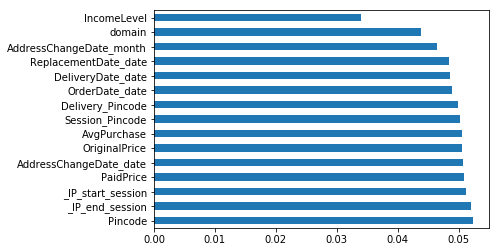

In [11]:
#feature importance
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [12]:
labels = labels.iloc[0:1500]
features = features.iloc[0:1500,:]
x=pd.DataFrame(features)
y=pd.DataFrame(labels)

In [13]:
# Scaling the Train and Test feature set 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_df = scaler.fit_transform(x)

#PCA
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(x)
x = pca.transform(x)

C:\Users\saraswathi\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\saraswathi\Anaconda2\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [14]:
#data split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state = 42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1050, 32), (450, 32), (1050, 1), (450, 1))

PARAMETER TUNING IN SVM

In [ ]:
#tuning SVM
#Import Library

from sklearn import svm
# Create SVM classification object 
model = svm.SVC(kernel='linear', C=.01, gamma=100) 
#changing kernel, gamma and C value. Will discuss more # about it in next section.Train the model using the training sets and check score
model.fit(x_train, y_train)
model.score(x_train, y_train)
#Predict Output
predicted= model.predict(x_test)
accuracy_score(predicted, y_test)


In [17]:
#decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

dtree = DecisionTreeClassifier(max_depth=10, random_state=101, max_features=None, min_samples_leaf=15)
dtree.fit(x_train,y_train)
y_pred= dtree.predict(x_test)
accuracy_score(y_pred, y_test)

0.6155555555555555

C:\Users\saraswathi\Anaconda2\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


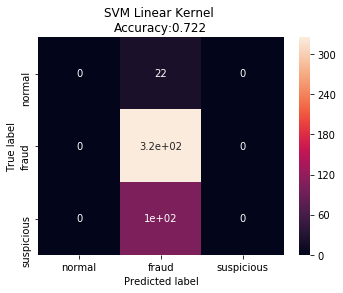

test sample size (450, 32) <class 'numpy.ndarray'>


In [18]:

clf = SVC(kernel = 'linear').fit(x_train,y_train)
clf.predict(x_train)
y_pred = clf.predict(x_test)

# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['normal','fraud','suspicious'], 
                     columns = ['normal','fraud','suspicious'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print("test sample size",x_test.shape,type(x_test))

In [ ]:
#gridsearch CV
parameter_candidates = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

from sklearn import svm
# Create a classifier object with the classifier and parameter candidates
clf = GridSearchCV(estimator=svm.SVC(), param_grid=parameter_candidates)

# Train the classifier on data1's feature and target data
clf.fit(x_train, y_train)   
# View the accuracy score
print('Best score for data1:', clf.best_score_) 

# View the best parameters for the model found using grid search
print('Best C:',clf.best_estimator_.C) 
print('Best Kernel:',clf.best_estimator_.kernel)
print('Best Gamma:',clf.best_estimator_.gamma)

# Apply the classifier trained using data1 to data2, and view the accuracy score
clf.score(x_test, y_test)

C:\Users\saraswathi\Anaconda2\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\saraswathi\Anaconda2\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\saraswathi\Anaconda2\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\saraswathi\Anaconda2\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

In [ ]:
from sklearn import metrics
# use the model to make predictions with the test data
y_pred = model.predict(x_test)
# how did our model perform?
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))


In [15]:
#Test harness
scalar = StandardScaler()
x_train = scalar.fit_transform(x_train)
x_test = scalar.transform(x_test)


In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [ ]:
#6 different algorithms
logis = LogisticRegression()
logis.fit(x_train,y_train)
prediction=logis.predict(x_test)
print("logistic regression::\n",confusion_matrix(y_test,prediction),"\n")

In [ ]:
#SVM
svm = SVC()
svm.fit(x_train,y_train)
prediction=svm.predict(x_test)
print("SVM ::\n",confusion_matrix(y_test, prediction),"\n")

In [ ]:
#KNN
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)
prediction=knn.predict(x_test)
print("KNN ::\n",confusion_matrix(y_test,prediction),"\n")

In [ ]:
#decisiontree
dTmodel = DecisionTreeClassifier()
dTmodel.fit(x_train,y_train)
prediction=dTmodel.predict(x_test)
print("DecisionTree ::\n",confusion_matrix(y_test,prediction),"\n")

In [ ]:
#randomforest
from sklearn.ensemble import RandomForestClassifier
rForest = RandomForestClassifier()
rForest.fit(x_train,y_train)
prediction=rForest.predict(x_test)
print("RandomForest ::\n",confusion_matrix(y_test,prediction),"\n")

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
# Cross Validation Score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
#gradientboosting
grBoosting = GradientBoostingClassifier()
grBoosting.fit(x_train,y_train)
prediction=grBoosting.predict(x_test)
print("GradientBoosting ::\n",confusion_matrix(y_test,prediction))

In [ ]:
#cross val_score
logis = LogisticRegression()
    
scores = cross_val_score(logis,x_train,y_train,cv=5)
print("Accuracy for logistic regresion: mean: {0:.2f} 2sd: {1:.2f}".format(scores.mean(),scores.std() * 2))
print("Scores::",scores)
print("\n")

scores2 = cross_val_score(svm,x_train,y_train,cv=5)
print("Accuracy for SVM: mean: {0:.2f} 2sd: {1:.2f}".format(scores2.mean(),scores2.std() * 2))
print("Scores::",scores)
print("\n")

scores3 = cross_val_score(knn,x_train,y_train,cv=5)
print("Accuracy for KNN: mean: {0:.2f} 2sd: {1:.2f}".format(scores3.mean(),scores3.std() * 2))
print("Scores::",scores)
print("\n")

scores4 = cross_val_score(dTmodel,x_train,y_train,cv=5)
print("Accuracy for Decision Tree: mean: {0:.2f} 2sd: {1:.2f}".format(scores4.mean(),scores4.std() * 2))
print("Scores::",scores4)
print("\n")

scores5 = cross_val_score(rForest,x_train,y_train,cv=5)
print("Accuracy for Random Forest: mean: {0:.2f} 2sd: {1:.2f}".format(scores5.mean(),scores5.std() * 2))
print("Scores::",scores5)
print("\n")

scores6 = cross_val_score(grBoosting,x_train,y_train,cv=5)
print("Accuracy for Gradient Boosting: mean: {0:.2f} 2sd: {1:.2f}".format(scores6.mean(),scores6.std() * 2))
print("Scores::",scores6)
print("\n")

In [ ]:
#Here we are testing various predictive algorithms from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import model_selection
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('Gradient Boosting', GradientBoostingClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=42)
    cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Cross Validation Score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

clf = RandomForestClassifier()
#Random Forest
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 4),
              "min_samples_split": sp_randint(2, 4),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 5
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)

random_search.fit(x_train, y_train)
print(random_search.best_params_)
print(random_search.best_estimator_)
confusion_matrix(y_test,random_search.predict(x_test))

In [ ]:
#SVM,LDA and LR have better accuracy than others
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
#making predictions
# Make predictions on validation dataset

svn.fit(x_train, y_train)
predictions = svn.predict(x_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))